Using device: cuda


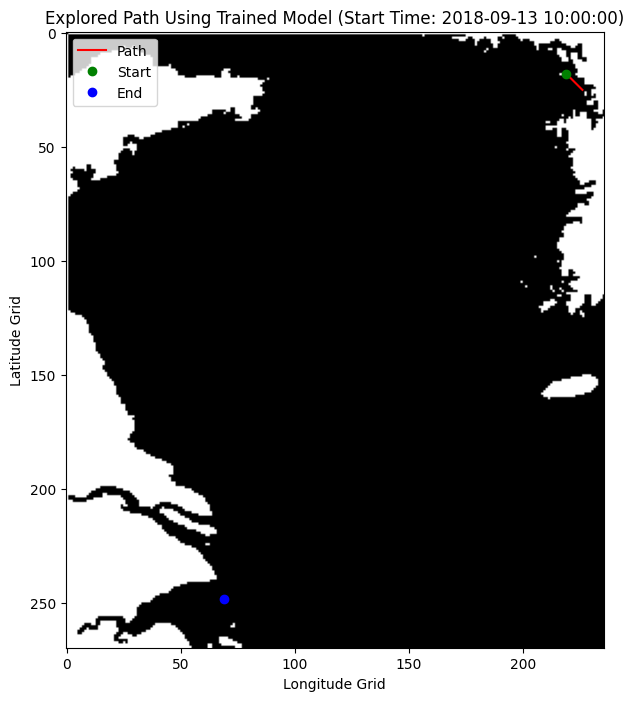

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime, timedelta

# CUDA 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dueling DQN 네트워크 정의
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)
        self.advantage_stream = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# 항해 환경 클래스
class NavigationEnv:
    def __init__(self):
        self.grid = np.load('land_sea_grid_cartopy_downsized.npy')  # 그리드 파일 경로를 실제 경로로 수정
        self.n_rows, self.n_cols = self.grid.shape
        self.lat_min, self.lat_max = 30.0, 38.0
        self.lon_min, self.lon_max = 120.0, 127.0
        self.start_pos = self.latlon_to_grid(37.46036, 126.52360)
        self.end_pos = self.latlon_to_grid(30.62828, 122.06400)
        self.step_time_minutes = 8.5
        self.max_steps = 300
        self.cumulative_time = 0
        self.step_count = 0
        self.tidal_data_dir = r"C:\baramproject\tidal_database_interpolated"  # 실제 경로로 수정
        self.wind_data_dir = r"C:\baramproject\wind_database_2"  # 실제 경로로 수정
        self.action_space = np.array([-90, -45, 0, 45, 90], dtype=np.float64)
        self.grid_directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
        self.grid_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315], dtype=np.float64)
        self.k_w = 0.005
        self.f_0 = 1.0
        self.V_s = 6.68
        self.path = []
        self.tidal_cache = {}
        self.wind_cache = {}
        self.reset()

    def latlon_to_grid(self, lat, lon):
        row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
        col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
        return row, col

    def reset(self, start_time=None):
        if start_time is None:
            start_date = datetime(2018, 1, 1, 0, 0)
            end_date = datetime(2018, 12, 29, 0, 0)
            time_delta = (end_date - start_date).total_seconds()
            random_seconds = np.random.randint(0, int(time_delta / 60 / 30) + 1) * 30 * 60
            start_time = start_date + timedelta(seconds=random_seconds)
        
        self.current_pos = self.start_pos
        self.current_direction = 0.0
        self.current_time = start_time
        self.cumulative_time = 0
        self.step_count = 0
        self.path = [self.current_pos]
        self.load_tidal_data()
        self.map_tidal_to_grid()
        self.load_wind_data()
        self.map_wind_to_grid()
        return self._get_state()

    def get_relative_position_and_angle(self):
        rel_pos = np.array(self.end_pos, dtype=np.float64) - np.array(self.current_pos, dtype=np.float64)
        distance = np.linalg.norm(rel_pos)
        end_angle = (np.degrees(np.arctan2(rel_pos[1], -rel_pos[0])) % 360.0)
        return rel_pos, distance, end_angle

    def angle_to_grid_direction(self, abs_action_angle):
        angle_diff = np.abs(self.grid_angles - abs_action_angle)
        closest_idx = np.argmin(angle_diff)
        return self.grid_directions[closest_idx]

    def load_data(self, data_dir, filename_prefix, time_str):
        cache = self.tidal_cache if filename_prefix == "tidal_" else self.wind_cache
        if time_str in cache:
            return cache[time_str]
        data_file = os.path.join(data_dir, f"{filename_prefix}{time_str}.json")
        if not os.path.exists(data_file):
            return None
        with open(data_file, 'r') as f:
            data = json.load(f)
        result = data["result"]["data"]
        cache[time_str] = result
        return result

    def map_tidal_to_grid(self):
        if self.tidal_data:
            positions = np.array([(float(item["lat"]), float(item["lon"])) for item in self.tidal_data], dtype=np.float64)
            directions = np.array([float(item["tidal_dir"]) for item in self.tidal_data], dtype=np.float64)
            speeds = np.array([float(item["tidal_speed"]) for item in self.tidal_data], dtype=np.float64)
            self.tidal_grid_dir, self.tidal_grid_speed, self.tidal_grid_valid = self.map_data_to_grid(
                positions, directions, speeds)
        else:
            self.tidal_grid_dir = np.zeros((self.n_rows, self.n_cols))
            self.tidal_grid_speed = np.zeros((self.n_rows, self.n_cols))
            self.tidal_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=bool)

    def load_tidal_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        self.tidal_data = self.load_data(self.tidal_data_dir, "tidal_", time_str)

    def map_wind_to_grid(self):
        if self.wind_data:
            positions = np.array([(float(item["pre_lat"]), float(item["pre_lon"])) for item in self.wind_data], dtype=np.float64)
            directions = np.array([float(item["wind_dir"]) for item in self.wind_data], dtype=np.float64)
            speeds = np.array([float(item["wind_speed"]) for item in self.wind_data], dtype=np.float64)
            self.wind_grid_dir, self.wind_grid_speed, self.wind_grid_valid = self.map_data_to_grid(
                positions, directions, speeds)
        else:
            self.wind_grid_dir = np.zeros((self.n_rows, self.n_cols))
            self.wind_grid_speed = np.zeros((self.n_rows, self.n_cols))
            self.wind_grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=bool)

    def load_wind_data(self):
        time_str = self.current_time.strftime("%Y%m%d_%H%M")
        self.wind_data = self.load_data(self.wind_data_dir, "wind_", time_str)

    def map_data_to_grid(self, positions, directions, speeds):
        grid_dir = np.zeros((self.n_rows, self.n_cols))
        grid_speed = np.zeros((self.n_rows, self.n_cols))
        grid_valid = np.zeros((self.n_rows, self.n_cols), dtype=bool)
        for i in range(len(positions)):
            lat, lon = positions[i]
            row = int((self.lat_max - lat) / (self.lat_max - self.lat_min) * self.n_rows)
            col = int((lon - self.lon_min) / (self.lon_max - self.lon_min) * self.n_cols)
            if 0 <= row < self.n_rows and 0 <= col < self.n_cols:
                grid_dir[row, col] = directions[i]
                grid_speed[row, col] = speeds[i]
                grid_valid[row, col] = True
        return grid_dir, grid_speed, grid_valid

    def step(self, action):
        self.step_count += 1
        rel_pos, _, end_angle = self.get_relative_position_and_angle()
        rel_action_angle = self.action_space[action]
        abs_action_angle = (end_angle + rel_action_angle) % 360.0
        move_dir = self.angle_to_grid_direction(abs_action_angle)
        new_pos = (self.current_pos[0] + move_dir[0], self.current_pos[1] + move_dir[1])
        
        if (0 <= new_pos[0] < self.n_rows and 0 <= new_pos[1] < self.n_cols and 
            self.grid[new_pos[0], new_pos[1]] == 0):
            self.current_pos = new_pos
            self.path.append(self.current_pos)
        
        self.cumulative_time += self.step_time_minutes
        if self.cumulative_time >= 30:
            self.current_time += timedelta(minutes=30)
            self.load_tidal_data()
            self.map_tidal_to_grid()
            self.load_wind_data()
            self.map_wind_to_grid()
            self.cumulative_time -= 30
        
        state = self._get_state()
        done = tuple(self.current_pos) == self.end_pos or self.step_count >= self.max_steps
        return state, 0, done, {}

    def _get_state(self):
        row, col = self.current_pos
        rel_pos, _, end_angle = self.get_relative_position_and_angle()
        tidal_dir = self.tidal_grid_dir[row, col] if self.tidal_grid_valid[row, col] else 0.0
        tidal_speed = self.tidal_grid_speed[row, col] if self.tidal_grid_valid[row, col] else 0.0
        wind_dir = self.wind_grid_dir[row, col] if self.wind_grid_valid[row, col] else 0.0
        wind_speed = self.wind_grid_speed[row, col] if self.wind_grid_valid[row, col] else 0.0
        return np.array([rel_pos[0], rel_pos[1], end_angle, tidal_dir, tidal_speed, wind_dir, wind_speed], dtype=np.float64)

# DQN 에이전트 클래스
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

# 경로 탐색 및 시각화 함수
def visualize_path(env, agent, model_path, start_time=None):
    agent.policy_net.load_state_dict(torch.load(model_path))
    agent.policy_net.eval()
    
    state = env.reset(start_time=start_time)
    done = False
    
    while not done:
        action = agent.select_action(state)
        state, _, done, _ = env.step(action)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(env.grid, cmap='gray', origin='upper')
    path_array = np.array(env.path)
    plt.plot(path_array[:, 1], path_array[:, 0], 'r-', label='Path')
    plt.plot(env.start_pos[1], env.start_pos[0], 'go', label='Start')
    plt.plot(env.end_pos[1], env.end_pos[0], 'bo', label='End')
    plt.legend()
    plt.title(f"Explored Path Using Trained Model (Start Time: {env.current_time})")
    plt.xlabel("Longitude Grid")
    plt.ylabel("Latitude Grid")
    plt.show()

# 메인 실행
if __name__ == "__main__":
    env = NavigationEnv()
    state_dim = 7
    action_dim = 5
    agent = DQNAgent(state_dim, action_dim)
    model_path = r"C:\baramproject\trained_model\new_sibal7\navigation_model.pth"
    
    start_time = datetime(2018, 9, 11, 15, 30)
    visualize_path(env, agent, model_path, start_time=start_time)